
#Part 3 : Term frequency analysis
## Intruduction
In this notebook we tried to figured out if there was a **difference in the content of quotations** between **Breitbart** and **Inside Climate News** journals. 

First we thought about performing a sentimental analysis of both groups of quotes but the results were really similar so we tried another way. Another problem was the different size of the sub dataset because Breitbart has much more quotations than Iniside Climate News. 

We find that **TF-IDF (term frequency-inverse document frequency)** matrix was a good way to see which words are proper to which journals and analyse this type of main words to make a conclusion. Indeed, the TF-IDF score is a numerical statistic that is intended to reflect how important a word is to a document in a collection. Moreover the fact that TF-IDF matrix take in count the recurrency of a word in all the quotations allows us to compare Breitbart and Inside Climate News without thinking about the size of the datasets.


##Data loading

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go

path_to_out_2015 = '/content/drive/MyDrive/Quotebank/quotes-2015-filtered.json.bz2'
path_to_out_2016 = '/content/drive/MyDrive/Quotebank/quotes-2016-filtered.json.bz2'
path_to_out_2017 = '/content/drive/MyDrive/Quotebank/quotes-2017-filtered.json.bz2'
path_to_out_2018 = '/content/drive/MyDrive/Quotebank/quotes-2018-filtered.json.bz2'
path_to_out_2019 = '/content/drive/MyDrive/Quotebank/quotes-2019-filtered.json.bz2'
path_to_out_2020 = '/content/drive/MyDrive/Quotebank/quotes-2020-filtered.json.bz2'
data_2015_df = pd.read_json(path_to_out_2015, lines=True)
data_2016_df = pd.read_json(path_to_out_2016, lines=True)
data_2017_df = pd.read_json(path_to_out_2017, lines=True)
data_2018_df = pd.read_json(path_to_out_2018, lines=True)
data_2019_df = pd.read_json(path_to_out_2019, lines=True)
data_2020_df = pd.read_json(path_to_out_2020, lines=True)

##Data processing
First of all we need to add the column domain_name to our imported data. For that we used the same process shown in Part 2 by using this code line : 

`data2020['domain_name'] = data2020.urls.map(lambda urls: [get_fld(el) for el in urls])`

Then we extract two datasets per year, one of Breitbart quotations and one of Inside Climate News.

Finally we create the three global datasets of all the years.

In [ ]:
# Compuate data for all years
data2020 = data_2020_df.copy()
data2020['domain_name'] = data2020.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2020  = data2020 [data2020 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2020  = data2020 [data2020 ['domain_name'].map(lambda x: 'breitbart.com' in x)]
data2019 = data_2019_df.copy()
data2019['domain_name'] = data2019.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2019  = data2019 [data2019 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2019  = data2019 [data2019 ['domain_name'].map(lambda x: 'breitbart.com' in x)]
data2018 = data_2018_df.copy()
data2018['domain_name'] = data2018.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2018  = data2018 [data2018 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2018  = data2018 [data2018 ['domain_name'].map(lambda x: 'breitbart.com' in x)]
data2017 = data_2017_df.copy()
data2017['domain_name'] = data2017.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2017  = data2017 [data2017 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2017  = data2017 [data2017 ['domain_name'].map(lambda x: 'breitbart.com' in x)]
data2016 = data_2016_df.copy()
data2016['domain_name'] = data2016.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2016  = data2016 [data2016 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2016  = data2016 [data2016 ['domain_name'].map(lambda x: 'breitbart.com' in x)]
data2015 = data_2015_df.copy()
data2015['domain_name'] = data2015.urls.map(lambda urls: [get_fld(el) for el in urls])
datainsideclimate2015  = data2015 [data2015 ['domain_name'].map(lambda x: 'carbonbrief.org' in x)]
databreibart2015  = data2015 [data2015 ['domain_name'].map(lambda x: 'breitbart.com' in x)]

frames = [datainsideclimate2020, databreibart2020,datainsideclimate2019, databreibart2019,datainsideclimate2018, databreibart2018,datainsideclimate2017, databreibart2017,datainsideclimate2016, databreibart2016,datainsideclimate2015, databreibart2015]
data = pd.concat(frames)
data.reset_index(drop = True, inplace = True)
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domain_name
0,2020-03-04-059449,The move comes less than a week after environm...,None,[],2020-03-04 09:50:20,1,"[[None, 0.6124], [Chris Packham, 0.3876]]",[https://www.carbonbrief.org/daily-brief/eu-me...,E,[carbonbrief.org]
1,2020-01-30-089670,The move would allow legal action against pers...,Greta Thunberg,[Q56434717],2020-01-30 09:55:21,1,"[[Greta Thunberg, 0.6067], [None, 0.3933]]",[https://www.carbonbrief.org/daily-brief/churc...,E,[carbonbrief.org]
2,2020-01-20-019692,hundreds of private jets carrying some of the ...,Ben Chapman,"[Q30122130, Q4885411, Q4885412, Q4885414, Q548...",2020-01-20 09:28:33,1,"[[Ben Chapman, 0.83], [Larry Elliott, 0.0853],...",[https://www.carbonbrief.org/daily-brief/its-j...,E,[carbonbrief.org]
3,2020-03-11-003062,alongside the government's plans for decarboni...,None,[],2020-03-11 18:32:54,1,"[[None, 0.9214], [Richard Black, 0.0786]]",[https://www.carbonbrief.org/budget-2020-key-c...,E,[carbonbrief.org]
4,2020-01-27-051967,Mr Musk deserves credit for establishing a pur...,Elon Musk,[Q317521],2020-01-27 09:45:20,1,"[[Elon Musk, 0.8577], [None, 0.1044], [Michael...",[https://www.carbonbrief.org/daily-brief/citiz...,E,[carbonbrief.org]


### Perform lemmatization on our quotes

We have implemented a function called `lemmatizeAbstracts()` that groups, or the abstracts using `spaCy` library. Considering that we are not interested in stylistic similarities between the quotations, this step helps to reduce the overall amount of features in our dataset. As part of the lemmatization function, we also clean the text of all punctuation and other noise such as brackets. In the following analysis, we will continue working with the lemmatized version of the quotations. 

In [ ]:
# lemmatization (optional step)
nlp = spacy.load("en_core_web_sm")

def lemmatizeAbstracts(x):
        doc = nlp(x)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        text_string = " ".join(new_text)
        # getting rid of non-word characters
        text_string = re.sub(r"[^\w\s]+", "", text_string)
        text_string = re.sub(r"\s{2,}", " ", text_string)
        return text_string

In [ ]:
# Compute an additionnal column for the lemmas
data["quotation_lemma"] = data["quotation"].apply(lemmatizeAbstracts)

###TD-IDF Vectorization

The first step is to create our TF-IDF model by passing it the argument to ignore stop words (the, a, etc). For the second step we are passing the quotations lemmatized from our general dataset to the vectorizer in order to convert them to machine-readable vectors. Finally, we create a new DataFrame based on the TF-IDF matrix of our textual data.

In [ ]:
# Calculate TF-IDF
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=250, strip_accents="unicode", min_df=10, max_df=200)
tfidf_array = tfidf.fit_transform(data["quotation_lemma"])
data_tfidf = pd.DataFrame(tfidf_array.toarray(), index=data.index, columns=tfidf.get_feature_names())
data_tfidf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,10,activity,agenda,ago,agree,ambition,ambitious,americans,approach,arctic,atmosphere,attack,australia,avoid,begin,believe pron,benefit,billion,biodiversity,burn,california,campaign,car,carbon emission,chance,claim,clean energy,clearly,climate action,climate pron,close,combat,commit,common,condition,conflict,consequence,consider,contribute,control,...,significant,simply,single,situation,small,social,society,solar,solve,source,speak,spend,standard,story,strategy,suggest,sustainable,tackle climate,tax,threaten,transition,tree,trend,trump administration,value,view,vote,want pron,washington,way pron,week,white,win,woman,word,work pron,world pron,wrong,year pron,young people
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.701279,0.0,0.712886,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508008,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Preparation of the analysis
Then in order to compare scores of different words in general, we compute the mean of the score for each words. We then sort the data from the higher mean score to the lower and add a column "word". In this way we will be able to vizualize directly the **most relevant words**.



In [ ]:
# Calculate medium score for each word
data_tfidfMean = data_tfidf.mean(0)
data_tfidfMean = data_tfidfMean.sort_values(ascending=False)
data_tfidfMeanDF = data_tfidfMean.to_frame()
data_tfidfMeanDF['Word'] = data_tfidfMeanDF.index
data_tfidfMeanDF = data_tfidfMeanDF.round(4)
data_tfidfMeanDF.head(20)

,0,Word
let pron,0.0046,let pron
small,0.0046,small
position,0.0045,position
sign,0.0045,sign
view,0.0045,view
emergency,0.0045,emergency
woman,0.0045,woman
arctic,0.0044,arctic
extinction,0.0044,extinction
sector,0.0044,sector


##Breibart and Inside Climate News Comparison

In order to obtain relevant average TF-IDF scores for the split Breitbart and Inside Climate News dataset, we extract the Breitbart and Inside Climate News TF-IDF matrix directly from the dataset TF-IDF matrix. As a reminder, the full dataset is the dataset created by concatenating the Breitbart citation dataset and the Inside Climate News citation dataset from each year.

In [ ]:
# Load data for InsideClimateNews and Breitbart 
datainsideclimateAll  = data[data['domain_name'].map(lambda x: 'insideclimatenews.org' in x)]
databreibartAll  = data[data['domain_name'].map(lambda x: 'breitbart.com' in x)]
databreibartAll.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domain_name,quotation_lemma
61,2020-01-02-070737,What would have been a bad fire season was mad...,None,[],2020-01-02 16:57:51,47,"[[None, 0.9607], [Robert Rohde, 0.0393]]",[http://www.breitbart.com/news/qa-how-climate-...,E,"[breitbart.com, thecourier.com, wtop.com, clic...",what would have be a bad fire season be make b...
80,2020-01-22-113813,What good is all the extra wealth in the world...,Prince Charles,[Q43274],2020-01-22 16:58:51,16,"[[Prince Charles, 0.7827], [None, 0.1953], [Gr...",[http://news.trust.org/item/20200122150129-juq...,E,"[trust.org, newshub.co.nz, pulse.com.gh, pulse...",what good be all the extra wealth in the world...
91,2020-01-14-082719,They are particularly disappointed with the on...,None,[],2020-01-14 00:00:00,72,"[[None, 0.5198], [James Murdoch, 0.3319], [Rup...",[http://nordic.businessinsider.com/james-murdo...,E,"[businessinsider.com, forbes.com, rawstory.com...",PRON be particularly disappointed with the ong...
93,2020-01-22-003311,After she goes and studies economics in colleg...,Steven Mnuchin,[Q24248265],2020-01-22 23:27:00,496,"[[Steven Mnuchin, 0.5672], [None, 0.2468], [Gr...",[https://www.marketwatch.com/story/mnuchin-to-...,E,"[marketwatch.com, businessinsider.com, busines...",after PRON go and study economic in college PR...
257,2020-01-14-084874,"This has been seen in many regions, including ...",Matthew Jones,"[Q10514004, Q16019107, Q1793338, Q20708110, Q2...",2020-01-14 07:05:07,10,"[[Matthew Jones, 0.8394], [None, 0.1499], [Iai...",[http://news.bbc.co.uk/news/science-environmen...,E,"[bbc.co.uk, breitbart.com, carbonbrief.org, da...",this have be see in many region include the we...


To do that we take the index of `datainsideclimateAll` corresponding to the lines from the whole dataset taken into Inside Climate News dataset, and then we localize the same lines in the TF-IDF matrix to extract only the scores of quotations of Inside Climate News. After that, we can compute the mean of this new sub TF-IDF matrix to obtain a easily interpretable dataframe.
We did the same for Breitbart quotations.

In [ ]:
# Extract TF-IDF for Breitbart and InsideClimateNews
idxC = datainsideclimateAll.index
TFIDF_c = data_tfidf.iloc[idxC]
idxB = databreibartAll.index
TFIDF_b = data_tfidf.iloc[idxB]

In [ ]:
# Compute means
TFIDF_b_Mean = TFIDF_b.mean(0)
TFIDF_b_Mean = TFIDF_b_Mean.sort_values(ascending=False)
TFIDF_b_MeanDF = TFIDF_b_Mean.to_frame()
TFIDF_b_MeanDF['Word'] = TFIDF_b_MeanDF.index
TFIDF_b_MeanDF = TFIDF_b_MeanDF.round(4)

TFIDF_c_Mean = TFIDF_c.mean(0)
TFIDF_c_Mean = TFIDF_c_Mean.sort_values(ascending=False)
TFIDF_c_MeanDF = TFIDF_c_Mean.to_frame()
TFIDF_c_MeanDF['Word'] = TFIDF_c_MeanDF.index
TFIDF_c_MeanDF = TFIDF_c_MeanDF.round(4)

##Visualization

In order to vizualize our results and we decide to plot the TD-IDF mean score per word in function of the number of recurrence of the word in all quotes mixed. The number of occurences is calculate on the whole dataset to remains consistent.

In [ ]:
# Prepare columns nb occurences and sources
C50 = TFIDF_c_MeanDF.head(50)
B50 = TFIDF_b_MeanDF.head(50)
A50 = data_tfidfMeanDF.head(50)

C50['nbOcc']=0
C50['Source'] = 'Inside Climate News'
B50['nbOcc']=0
B50['Source'] = 'Breibart'
A50['nbOcc']=0
A50['Source'] = 'Both'

In [ ]:
# Fill nb occurences for each word for Breitbart and InsideClimateNews
for i in range(0,len(C50)):
  df = data.copy()
  df = df[df['quotation'].map(lambda x: C50['Word'][i] in x)]
  C50['nbOcc'][i] = len(df)

for i in range(0,len(B50)):
  df = data.copy()
  df = df[df['quotation'].map(lambda x: B50['Word'][i] in x)]
  B50['nbOcc'][i] = len(df)

for i in range(0,len(A50)):
  df = data.copy()
  df = df[df['quotation'].map(lambda x: A50['Word'][i] in x)]
  A50['nbOcc'][i] = len(df)

In [ ]:
# Rename columns
C50.columns = ['Relevancy Score','Word','Reccurency of the word in all the quotations','Source']
B50.columns = ['Relevancy Score','Word','Reccurency of the word in all the quotations','Source']
A50.columns = ['Relevancy Score','Word','Reccurency of the word in all the quotations','Source']

In [ ]:
# Prepare data for visualisation
framesTF = [C50,B50,A50]
dataTF = pd.concat(framesTF)
dataTF.columns = ['Relevancy Score','Word','Reccurency of the word in all the quotations','Source']
dataTF.head()

,Relevancy Score,Word,Reccurency of the word in all the quotations,Source
epa,0.0200,epa,305,Inside Climate News
project,0.0155,project,237,Inside Climate News
federal,0.0116,federal,152,Inside Climate News
line,0.0108,line,514,Inside Climate News
solar,0.0100,solar,158,Inside Climate News


In [ ]:
# Scatter plot of the words by the relevant score and occurences
import plotly.express as px

fig1 = px.scatter(dataTF, y="Reccurency of the word in all the quotations", x="Relevancy Score", color="Source", symbol="Source",hover_name="Word", log_x = True, log_y = True)
fig1.update_traces(marker_size=10)
fig1.show()
fig1.write_html('/content/drive/MyDrive/Scatter1.html')

###Interpretation of the results
In this analysis we used TF-IDF mean score to represent the relevance of the words used by each journal. Indeed, as the TF-IDF score is the recurrence of a word in a quotation divided by its recurrence in all the quotations mixed, it is a good indicator for us. A word with a high score is thus used a lot in a citation but is rarer in other quotations. 

On the graph above we can clearly see a difference between Breitbart and Inside Climate News !! And after seeing this difference we discovered that moreover there is way more words directly linked to climate issues in the top scored words of Inside Climate News than in Breitbart. You can saw that in the table below.


In [ ]:
# Plot recap table
fig2 = go.Figure(data=[go.Table(header=dict(values=['Breibart', 'Relevancy Score','Inside Climate News', 'Relevancy Score','Both', 'Relevancy Score']),
                 cells=dict(values=[[TFIDF_b_MeanDF['Word'][0], TFIDF_b_MeanDF['Word'][1],TFIDF_b_MeanDF['Word'][2],TFIDF_b_MeanDF['Word'][3],TFIDF_b_MeanDF['Word'][4],TFIDF_b_MeanDF['Word'][5],TFIDF_b_MeanDF['Word'][6],TFIDF_b_MeanDF['Word'][7],TFIDF_b_MeanDF['Word'][8],TFIDF_b_MeanDF['Word'][9],TFIDF_b_MeanDF['Word'][10],TFIDF_b_MeanDF['Word'][11],TFIDF_b_MeanDF['Word'][12],TFIDF_b_MeanDF['Word'][13],TFIDF_b_MeanDF['Word'][14],TFIDF_b_MeanDF['Word'][15],TFIDF_b_MeanDF['Word'][16],TFIDF_b_MeanDF['Word'][17],TFIDF_b_MeanDF['Word'][18],TFIDF_b_MeanDF['Word'][19]], 
                                    [TFIDF_b_MeanDF[0][0], TFIDF_b_MeanDF[0][1],TFIDF_b_MeanDF[0][2],TFIDF_b_MeanDF[0][3],TFIDF_b_MeanDF[0][4],TFIDF_b_MeanDF[0][5],TFIDF_b_MeanDF[0][6],TFIDF_b_MeanDF[0][7],TFIDF_b_MeanDF[0][8],TFIDF_b_MeanDF[0][9],TFIDF_b_MeanDF[0][10],TFIDF_b_MeanDF[0][11],TFIDF_b_MeanDF[0][12],TFIDF_b_MeanDF[0][13],TFIDF_b_MeanDF[0][14],TFIDF_b_MeanDF[0][15],TFIDF_b_MeanDF[0][16],TFIDF_b_MeanDF[0][17],TFIDF_b_MeanDF[0][18],TFIDF_b_MeanDF[0][19]],
                                    [TFIDF_c_MeanDF['Word'][0], TFIDF_c_MeanDF['Word'][1],TFIDF_c_MeanDF['Word'][2],TFIDF_c_MeanDF['Word'][3],TFIDF_c_MeanDF['Word'][4],TFIDF_c_MeanDF['Word'][5],TFIDF_c_MeanDF['Word'][6],TFIDF_c_MeanDF['Word'][7],TFIDF_c_MeanDF['Word'][8],TFIDF_c_MeanDF['Word'][9],TFIDF_c_MeanDF['Word'][10],TFIDF_c_MeanDF['Word'][11],TFIDF_c_MeanDF['Word'][12],TFIDF_c_MeanDF['Word'][13],TFIDF_c_MeanDF['Word'][14],TFIDF_c_MeanDF['Word'][15],TFIDF_c_MeanDF['Word'][16],TFIDF_c_MeanDF['Word'][17],TFIDF_c_MeanDF['Word'][18],TFIDF_c_MeanDF['Word'][19]],
                                    [TFIDF_c_MeanDF[0][0], TFIDF_c_MeanDF[0][1],TFIDF_c_MeanDF[0][2],TFIDF_c_MeanDF[0][3],TFIDF_c_MeanDF[0][4],TFIDF_c_MeanDF[0][5],TFIDF_c_MeanDF[0][6],TFIDF_c_MeanDF[0][7],TFIDF_c_MeanDF[0][8],TFIDF_c_MeanDF[0][9],TFIDF_c_MeanDF[0][10],TFIDF_c_MeanDF[0][11],TFIDF_c_MeanDF[0][12],TFIDF_c_MeanDF[0][13],TFIDF_c_MeanDF[0][14],TFIDF_c_MeanDF[0][15],TFIDF_c_MeanDF[0][16],TFIDF_c_MeanDF[0][17],TFIDF_c_MeanDF[0][18],TFIDF_c_MeanDF[0][19]],
                                    [data_tfidfMeanDF['Word'][0], data_tfidfMeanDF['Word'][1],data_tfidfMeanDF['Word'][2],data_tfidfMeanDF['Word'][3],data_tfidfMeanDF['Word'][4],data_tfidfMeanDF['Word'][5],data_tfidfMeanDF['Word'][6],data_tfidfMeanDF['Word'][7],data_tfidfMeanDF['Word'][8],data_tfidfMeanDF['Word'][9],data_tfidfMeanDF['Word'][10],data_tfidfMeanDF['Word'][11],data_tfidfMeanDF['Word'][12],data_tfidfMeanDF['Word'][13],data_tfidfMeanDF['Word'][14],data_tfidfMeanDF['Word'][15],data_tfidfMeanDF['Word'][16],data_tfidfMeanDF['Word'][17],data_tfidfMeanDF['Word'][18],data_tfidfMeanDF['Word'][19]], 
                                    [data_tfidfMeanDF[0][0], data_tfidfMeanDF[0][1],data_tfidfMeanDF[0][2],data_tfidfMeanDF[0][3],data_tfidfMeanDF[0][4],data_tfidfMeanDF[0][5],data_tfidfMeanDF[0][6],data_tfidfMeanDF[0][7],data_tfidfMeanDF[0][8],data_tfidfMeanDF[0][9],data_tfidfMeanDF[0][10],data_tfidfMeanDF[0][11],data_tfidfMeanDF[0][12],data_tfidfMeanDF[0][13],data_tfidfMeanDF[0][14],data_tfidfMeanDF[0][15],data_tfidfMeanDF[0][16],data_tfidfMeanDF[0][17],data_tfidfMeanDF[0][18],data_tfidfMeanDF[0][19]]]))
                     ])
fig2.show()
fig2.write_html('/content/drive/MyDrive/TFIDF2.html')

To support this discovery and used it in our data story we created word clouds where the size of words is proportionnal to its mean TF-IDF score. 

In [ ]:
# Set up to generate wordclouds
dB = []
dB20 = TFIDF_b_MeanDF.head(50)
for i in range(0,len(dB20)):
  dB.append((TFIDF_b_MeanDF['Word'][i],TFIDF_b_MeanDF[0][i]))
dB = list(filter(lambda x : x[0].count('pron')==0, dB))

dC = []
dC20 = TFIDF_c_MeanDF.head(50)
for i in range(0,len(dC20)):
  dC.append((TFIDF_c_MeanDF['Word'][i],TFIDF_c_MeanDF[0][i]))
dC = list(filter(lambda x : x[0].count('pron')==0, dC))

dA = []
dA20 = data_tfidfMeanDF.head(50)
for i in range(0,len(dA20)):
  dA.append((data_tfidfMeanDF['Word'][i],data_tfidfMeanDF[0][i]))
dA = list(filter(lambda x : x[0].count('pron')==0, dA))


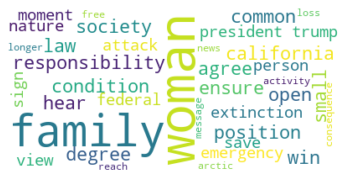

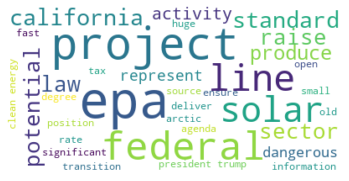

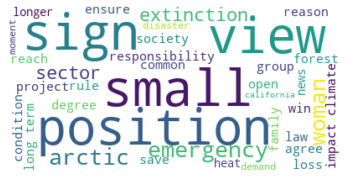

In [ ]:
# Generate word clouds for Breitbart, InsideClimateNews and Both words attribution
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

def wordcloud_process(text,i):
  wordcloud = WordCloud(background_color="white",mask=None, max_words=100, max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
  contour_width=3,contour_color='black').fit_words(dict(text))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.savefig("/content/drive/MyDrive/Quotebank/WordCloud#"+str(i)+'.png', format="png")
  plt.show()

wordcloud_process(dB,0)
wordcloud_process(dC,1)
wordcloud_process(dA,2)